# Restaurant Revenue Prediction

# Importing Libraries, Loading Data, EDA, Data Preprocessing, Feature Selection and Normalization, Model Building

Train data shape: (137, 43)
Test data shape: (100000, 42)
Train columns: Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')
Test columns: Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37'],
      dtype='object')
Missing values in train data:
 Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5           

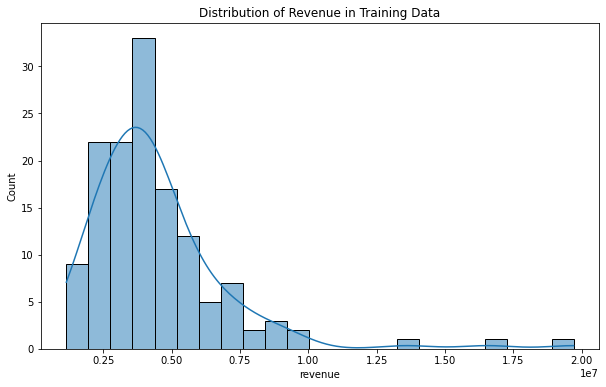

Transformed training data shape after feature selection: (137, 10)
Transformed test data shape after feature selection: (100000, 10)
Random Forest RMSE: 3266855.7595323743
Decision Tree RMSE: 3506768.7904327866
SVR RMSE: 3607694.057201298
MLP RMSE: 5903166.119717886
SGD Regressor RMSE: 3721329.2507195408


In [1]:
# Step 1: Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


# Step 2: Loading the data

train = pd.read_csv(r'C:\Users\ayush\Downloads\restaurant-revenue-prediction\train1.csv')
test = pd.read_csv(r'C:\Users\ayush\Downloads\restaurant-revenue-prediction\test1.csv')

# Checking the columns and first few rows to ensure the data is loaded correctly
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

# Check column names
print("Train columns:", train.columns)
print("Test columns:", test.columns)

# Step 3: Perform EDA

# Check for missing values
print("Missing values in train data:\n", train.isnull().sum())
print("Missing values in test data:\n", test.isnull().sum())

# Summary statistics
print("Train data summary:\n", train.describe())
print("Test data summary:\n", test.describe())

# Visualize distributions (if required)
plt.figure(figsize=(10, 6))
sns.histplot(train['revenue'], kde=True)
plt.title('Distribution of Revenue in Training Data')
plt.show()

# Fill missing values for numerical columns with the mean
train.fillna(train.mean(), inplace=True)  
test.fillna(test.mean(), inplace=True)

# Drop unnecessary columns (e.g., 'Id' and 'Open Date') if they exist
columns_to_drop = ['Id', 'Open Date']
train.drop(columns=[col for col in columns_to_drop if col in train.columns], inplace=True)
test.drop(columns=[col for col in columns_to_drop if col in test.columns], inplace=True)

# Separate features (X) and target variable (y) in the training data
X_train = train.drop('revenue', axis=1)  # Drop 'revenue' from features
y_train = train['revenue']  # Target variable

# Test data should not include 'revenue' (as it is not part of the test set)
X_test = test  # Features in test set

# Step 4: Preprocess, Feature Selection, and Normalization

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Identify categorical columns
categorical_cols = ['City', 'City Group', 'Type']  # These are the columns with string values

# Separate the categorical and numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create the preprocessor with OneHotEncoding for categorical columns and StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_cols),  # StandardScaler for numerical columns
                  ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # OneHotEncoder for categorical
    ])

# Apply the preprocessor to the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Train a Random Forest Regressor to obtain feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)  # Fit the Random Forest model to the processed data

# Use SelectFromModel to select important features based on the feature importances from the Random Forest
selector = SelectFromModel(rf, threshold="mean", max_features=10, prefit=True)  # Set prefit=True

# Apply the feature selection to both train and test sets
X_train_selected = selector.transform(X_train_processed)  # Transform training data to select important features
X_test_selected = selector.transform(X_test_processed)  # Transform test data to select important features

# Check the shape after feature selection
print(f"Transformed training data shape after feature selection: {X_train_selected.shape}")
print(f"Transformed test data shape after feature selection: {X_test_selected.shape}")

# Step 5: Split the Data into Training and Testing Sets

# Use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

# Step 6: Normalize the Data (Optional but often improves performance for certain models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit to X_train and transform
X_test_scaled = scaler.transform(X_test)  # Only transform X_test

# Step 7: Initialize Models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'SGD Regressor': SGDRegressor(random_state=42)
}

# Step 8: Train and Evaluate Models, including RMSE Calculation
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the RMSE for each model
    print(f'{name} RMSE: {rmse}')


# Hyperparameter Tuning of Regressor Models

In [2]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Random Forest Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=rf_param_grid, 
                                      n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

rf_random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters for Random Forest: ", rf_random_search.best_params_)

# 2. Decision Tree Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

dt_random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), param_distributions=dt_param_grid, 
                                      n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

dt_random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters for Decision Tree: ", dt_random_search.best_params_)

# 3. Support Vector Regressor (SVR) Hyperparameter Tuning
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'poly', 'rbf']
}

svr_random_search = RandomizedSearchCV(SVR(), param_distributions=svr_param_grid, 
                                       n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

svr_random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters for SVR: ", svr_random_search.best_params_)

# 4. Multi-Layer Perceptron (MLP) Hyperparameter Tuning
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_random_search = RandomizedSearchCV(MLPRegressor(random_state=42), param_distributions=mlp_param_grid, 
                                       n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

mlp_random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters for MLP: ", mlp_random_search.best_params_)

# 5. SGD Regressor Hyperparameter Tuning
sgd_param_grid = {
    'penalty': ['none', 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 1500, 2000]
}

sgd_random_search = RandomizedSearchCV(SGDRegressor(random_state=42), param_distributions=sgd_param_grid, 
                                       n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

sgd_random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters for SGD Regressor: ", sgd_random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Random Forest:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Decision Tree:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for SVR:  {'kernel': 'linear', 'epsilon': 0.1, 'C': 100}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for MLP:  {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150,), 'activation': 'tanh'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for SGD Regressor:  {'penalty': 'l2', 'max_iter': 1500, 'alpha': 0.001}


In [3]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluating Random Forest
rf_best_model = rf_random_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test_scaled)

# RMSE for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

# Evaluating Decision Tree
dt_best_model = dt_random_search.best_estimator_
y_pred_dt = dt_best_model.predict(X_test_scaled)

# RMSE for Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree - RMSE: {rmse_dt:.4f}, R²: {r2_dt:.4f}")

# Evaluating SVR
svr_best_model = svr_random_search.best_estimator_
y_pred_svr = svr_best_model.predict(X_test_scaled)

# RMSE for SVR
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR - RMSE: {rmse_svr:.4f}, R²: {r2_svr:.4f}")

# Evaluating MLP Regressor
mlp_best_model = mlp_random_search.best_estimator_
y_pred_mlp = mlp_best_model.predict(X_test_scaled)

# RMSE for MLP
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Regressor - RMSE: {rmse_mlp:.4f}, R²: {r2_mlp:.4f}")

# Evaluating SGD Regressor
sgd_best_model = sgd_random_search.best_estimator_
y_pred_sgd = sgd_best_model.predict(X_test_scaled)

# RMSE for SGD Regressor
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))
r2_sgd = r2_score(y_test, y_pred_sgd)

print(f"SGD Regressor - RMSE: {rmse_sgd:.4f}, R²: {r2_sgd:.4f}")


Random Forest - RMSE: 3329556.2679, R²: 0.0938
Decision Tree - RMSE: 3333452.1706, R²: 0.0917
SVR - RMSE: 3612264.4346, R²: -0.0666
MLP Regressor - RMSE: 3577744.1894, R²: -0.0463
SGD Regressor - RMSE: 3720325.8441, R²: -0.1313


# Stacking Model Creation

In [4]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Base models (already tuned)
base_learners = [
    ('rf', rf_best_model),  # Random Forest
    ('dt', dt_best_model),  # Decision Tree
    ('svr', svr_best_model),  # Support Vector Regressor
    ('mlp', mlp_best_model),  # MLP Regressor
    ('sgd', sgd_best_model)  # SGD Regressor
]

# Meta-model (Linear Regression)
meta_model = LinearRegression()

# Stacking Regressor
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train)
print(stacking_model)
# Predictions using the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled)
print(type(stacking_model))

# Evaluate the stacking model
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Model - RMSE: {rmse_stack:.4f}, R²: {r2_stack:.4f}")


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                              ('dt',
                               DecisionTreeRegressor(max_depth=20,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     random_state=42)),
                              ('svr', SVR(C=100, kernel='linear')),
                              ('mlp',
                               MLPRegressor(activation='tanh',
                                            hidden_layer_sizes=(150,),
                                        

# HyperParameter Tuning of Stacking Model

In [5]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid for the meta-model (Ridge in this case)
param_grid_meta = {
    'final_estimator__alpha': [0.1, 1, 10, 100, 1000],  # for Ridge (meta-model)
}

# Stack the best models with the meta-model (Ridge)
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=Ridge())

# Use RandomizedSearchCV for the stacking model
stacking_search = RandomizedSearchCV(stacking_model, param_grid_meta, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
stacking_search.fit(X_train_scaled, y_train)

# Best Stacking Model
best_stacking_model = stacking_search.best_estimator_
print(f"Best Stacking Model parameters: {stacking_search.best_params_}")
print(stacking_model)
print(dir(stacking_model))  # This will show all the available attributes and methods

# Predictions using the best stacked model
y_pred_stack = best_stacking_model.predict(X_test_scaled)

# Evaluate the best stacking model
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Model - RMSE: {rmse_stack:.4f}, R²: {r2_stack:.4f}")


Best Stacking Model parameters: {'final_estimator__alpha': 0.1}
StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                              ('dt',
                               DecisionTreeRegressor(max_depth=20,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     random_state=42)),
                              ('svr', SVR(C=100, kernel='linear')),
                              ('mlp',
                               MLPRegressor(activation='tanh',
                                            hid

In [6]:
# Check the column names of the test DataFrame
print(test.columns)

Index(['City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7',
       'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27',
       'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37'],
      dtype='object')


# Generating Predictions and Submission files of Individual and Stacked Model

In [7]:
# Add a new column 'ID' based on row index
test['ID'] = test.index

# Create the base submission DataFrame with the new 'ID' column
submission_base = pd.DataFrame({'ID': test['ID']})

# Dictionary to store predictions from individual models
individual_model_predictions = {
    "Decision Tree": dt_best_model.predict(X_test_selected),
    "Random Forest": rf_best_model.predict(X_test_selected),
    "SVR": svr_best_model.predict(X_test_selected),
    "MLP": mlp_best_model.predict(X_test_selected),
    "SGD": sgd_best_model.predict(X_test_selected),
}

# Save predictions for each individual model
for model_name, predictions in individual_model_predictions.items():
    submission = submission_base.copy()
    submission['Prediction'] = predictions
    filename = f'C:\\Users\\ayush\\Downloads\\{model_name.replace(" ", "_").lower()}_submission.csv'
    submission.to_csv(filename, index=False)
    print(f"Saved {model_name} submission to: {filename}")

# Stacked model predictions
stacked_predictions = best_stacking_model.predict(X_test_selected)  # Stacked model predictions
stacked_submission = submission_base.copy()
stacked_submission['Prediction'] = stacked_predictions
stacked_filename = r'C:\Users\ayush\Downloads\stacked_model_submission.csv'
stacked_submission.to_csv(stacked_filename, index=False)
print(f"Saved Stacked Model submission to: {stacked_filename}")


Saved Decision Tree submission to: C:\Users\ayush\Downloads\decision_tree_submission.csv
Saved Random Forest submission to: C:\Users\ayush\Downloads\random_forest_submission.csv
Saved SVR submission to: C:\Users\ayush\Downloads\svr_submission.csv
Saved MLP submission to: C:\Users\ayush\Downloads\mlp_submission.csv
Saved SGD submission to: C:\Users\ayush\Downloads\sgd_submission.csv
Saved Stacked Model submission to: C:\Users\ayush\Downloads\stacked_model_submission.csv


In [8]:
train.shape

(137, 41)

In [9]:
test.shape

(100000, 41)

# Feature Selection using SequentialFeatureSelector and redoing Regression Models

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Assuming X_train and y_train are already defined
# Let's scale the features before feature selection
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'MLP': MLPRegressor(max_iter=1000)
}

# Initialize the number of features to select
n_features_to_select = 9  # You can change this number

# Function to calculate RMSE and R2 for each model
def evaluate_model(model, X_train, y_train, X_test, y_test, n_features_to_select):
    # Perform sequential feature selection
    selector = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, direction='forward', cv=5)
    selector.fit(X_train, y_train)

    # Get the selected features
    selected_features = selector.get_support()

    # Train model with selected features
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_selected)
    
    # Calculate RMSE and R2
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return rmse, r2

# Split data into train/test (or use your predefined data)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Dictionary to store performance metrics
performance = {}

# Loop through models and evaluate
for model_name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test, n_features_to_select)
    performance[model_name] = {'RMSE': rmse, 'R2': r2}

# Print performance metrics
for model_name, metrics in performance.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")


Random Forest:
  RMSE: 3392329.7664
  R2: 0.0526
Decision Tree:
  RMSE: 3682037.7844
  R2: -0.1161
MLP:
  RMSE: 6139118.1284
  R2: -2.1026


# Feature Selection Using GeneticSelectionCV using deap Module and redoing Regression Models

In [15]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assume X_train and y_train are predefined

# Initialize creator to maximize fitness (higher fitness is better)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define evaluation function (e.g., use RMSE as the objective to minimize)
def evaluate(individual, model, X_train, y_train):
    selected_features = [index for index, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:  # Avoid empty feature set
        return 0,
    
    # Select the features from the dataset
    X_selected = X_train[:, selected_features]
    
    # Calculate RMSE using cross-validation
    rmse = -cross_val_score(model, X_selected, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()
    
    return rmse,

# Create a population of individuals (binary feature selection)
def create_individual():
    return [random.randint(0, 1) for _ in range(X_train.shape[1])]

# Initialize models for evaluation
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'MLP': MLPRegressor(max_iter=1000)
}

# Initialize the population and set up the evolutionary algorithm
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the genetic algorithm
def run_genetic_algorithm(model, X_train, y_train):
    population = toolbox.population(n=50)
    
    # Define the evaluation function in the DEAP framework
    toolbox.register("evaluate", evaluate, model=model, X_train=X_train, y_train=y_train)
    
    # Run the evolutionary algorithm
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=40, verbose=True)
    
    return population

# Split data into train/test (you should have X_train and y_train already defined)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Loop through models, run the genetic algorithm and evaluate performance
performance = {}

for model_name, model in models.items():
    # Run the genetic algorithm for feature selection
    population = run_genetic_algorithm(model, X_train, y_train)
    
    # Extract the best individual (best feature set)
    best_individual = tools.selBest(population, 1)[0]
    selected_features = [index for index, bit in enumerate(best_individual) if bit == 1]
    print(f"Selected features for {model_name}: {selected_features}")
    
    # Train the model using the selected features
    X_selected = X_train[:, selected_features]
    model.fit(X_selected, y_train)
    
    # Evaluate on test data
    X_test_selected = X_test[:, selected_features]
    y_pred = model.predict(X_test_selected)
    
    # Calculate RMSE for the selected features
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    performance[model_name] = {'RMSE': rmse}
    print(f"RMSE for {model_name} with selected features: {rmse:.4f}")

# Print performance metrics for all models
for model_name, metrics in performance.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")


gen	nevals
0  	50    
1  	37    
2  	35    
3  	38    
4  	44    
5  	31    
6  	37    
7  	41    
8  	40    
9  	44    
10 	34    
11 	45    
12 	41    
13 	48    
14 	36    
15 	40    
16 	36    
17 	36    
18 	41    
19 	39    
20 	36    
21 	37    
22 	37    
23 	40    
24 	39    
25 	40    
26 	37    
27 	39    
28 	35    
29 	39    
30 	34    
31 	36    
32 	37    
33 	37    
34 	38    
35 	33    
36 	38    
37 	36    
38 	42    
39 	37    
40 	41    
Selected features for Decision Tree: [0, 1, 2, 3, 5, 6, 8, 9]
RMSE for Decision Tree with selected features: 1985643.9273
gen	nevals
0  	50    
1  	36    
2  	38    
3  	40    
4  	34    
5  	34    
6  	40    
7  	42    
8  	40    
9  	34    
10 	37    
11 	31    
12 	35    
13 	43    
14 	40    
15 	42    
16 	38    
17 	36    
18 	38    
19 	37    
20 	41    
21 	33    
22 	30    
23 	41    
24 	44    
25 	39    
26 	41    
27 	39    
28 	35    
29 	30    
30 	34    
31 	31    
32 	44    
33 	38    
34 	42    
35 	44    
36 	45   

In [16]:
!pip install sklearn-genetic

  Using cached sklearn_genetic-0.6.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached multiprocess-0.70.17-py39-none-any.whl.metadata (7.2 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
Using cached sklearn_genetic-0.6.0-py3-none-any.whl (11 kB)
Using cached multiprocess-0.70.17-py39-none-any.whl (133 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)



[notice] A new release of pip is available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 483, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\_internal\metadata\pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "C:\Users\ayush\anaconda3\lib\site-packages\pip\

In [17]:
from genetic_selection import GeneticSelectionCV

# Feature Selection Using GeneticSelectionCV and redoing Regression Models

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'MLP': MLPRegressor(max_iter=1000)
}

# Function to calculate RMSE and R2 for each model
def evaluate_model_with_genetic_selection(model, X_train, y_train, X_test, y_test):
    # Perform genetic feature selection
    selector = GeneticSelectionCV(estimator=model,
                                  cv=5,  # Number of cross-validation folds
                                  verbose=0,  # Set to 1 or 2 to get verbose output
                                  scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
                                  n_population=20,  # Number of individuals in the population
                                  crossover_proba=0.5,  # Probability of crossover
                                  n_generations=20,  # Number of generations
                                  n_jobs=-1)  # Use all cores available
    
    # Fit the selector to the data
    selector = selector.fit(X_train, y_train)
    
    # Get the selected features
    selected_features = selector.support_

    # Check if any features were selected
    if np.sum(selected_features) == 0:
        print(f"Warning: No features selected for model {model}")
        return None, None, None
    
    # Train model with selected features
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_selected)
    
    # Calculate RMSE and R2
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return rmse, r2, selected_features

# Split data into train/test (or use your predefined data)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Dictionary to store performance metrics
performance = {}

# Loop through models and evaluate
for model_name, model in models.items():
    rmse, r2, selected_features = evaluate_model_with_genetic_selection(model, X_train, y_train, X_test, y_test)
    
    if rmse is not None and r2 is not None:
        performance[model_name] = {'RMSE': rmse, 'R2': r2, 'Selected Features': selected_features}
    else:
        print(f"Skipping model {model_name} due to feature selection failure")

# Print performance metrics
for model_name, metrics in performance.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")
    print(f"  Selected Features: {np.where(metrics['Selected Features'])[0]}")

Random Forest:
  RMSE: 1752541.8435
  R2: -0.2254
  Selected Features: [0 4 7 8]
Decision Tree:
  RMSE: 1565031.2270
  R2: 0.0228
  Selected Features: [0 2 3 4 6 7 8]
MLP:
  RMSE: 4900108.9652
  R2: -8.5798
  Selected Features: [0 1 2 3 4 5 6 7 9]
